In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
# nb_dir = os.path.split(os.getcwd())[0]
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)
    

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from NetAnom import NodeClassifier
from NetAnom import load_tissue_graph, get_gdf

ModuleNotFoundError: No module named 'NetAnom'

In [4]:
import pickle

In [5]:
from mlxtend.classifier import StackingCVClassifier
import networkx as nx
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from karateclub.node_embedding.neighbourhood import Node2Vec
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

In [6]:
tissue_path = Path("Tissue Networks/")
models_path = Path("models")
out_path = Path("out")

In [7]:
disease_info = pd.read_csv("data/Disease_Info.csv")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("{")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("}")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("?")
disease_info["Tissue"] = disease_info["Tissue"].str.replace("-", " ")

In [8]:
tissue_mapping = pd.read_csv("data/tissue_mapping_new.csv")


In [9]:
tissue_mapping = tissue_mapping.dropna()

In [10]:
tissue_mapping = tissue_mapping.merge(pd.DataFrame(disease_info.drop_duplicates(subset=["Tissue","Gene_ID"]).groupby("Tissue").size()), left_on="tissue_name_disease_file", right_on="Tissue", how="left")
tissue_mapping = tissue_mapping.rename(columns={0:"disease_nodes_num"})

In [11]:
tissue_mapping = tissue_mapping[tissue_mapping["disease_nodes_num"]>20]

In [12]:
tissue_mapping = tissue_mapping[~tissue_mapping.tissue_name_network_file.isin(["Breast Mammary Tissue", "Minor Salivary Gland"])]

## Generate Embedding

In [13]:
# from karateclub.node_embedding.neighbourhood import Node2Vec

# tissue_name = tissue_mapping.iloc[0]["tissue_name_network_file"]
# tissue_disease_file_name = tissue_mapping.iloc[0]["tissue_name_disease_file"]
# ""
# g = load_tissue_graph(tissue_name, tissue_disease_file_name)
# g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
# for v, u in tqdm(g_num.edges, total=g_num.number_of_edges()):
#     g_num[v][u].pop("weight")
#     # g_num[v][u]["interaction"] =  g_num[v][u].pop("weight")


# model = Node2Vec()

# model.fit(g_num)

In [14]:
from karateclub.node_embedding.neighbourhood import Node2Vec, RandNE
for _, row in tissue_mapping.iterrows():
    tissue_name = row["tissue_name_network_file"]
    tissue_disease_file_name = row["tissue_name_disease_file"]

    g = load_tissue_graph(tissue_path, tissue_name, tissue_disease_file_name, disease_info)
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")

    model = RandNE()

    model.fit(g_num)
    
    edge_df = nx.convert_matrix.to_pandas_edgelist(g_num)
    edge_df["source"] = edge_df["source"].astype(int)
    edge_df["target"] = edge_df["target"].astype(int)
    edge_df = get_gdf(g)
    edge_df["features"] = edge_df.apply(lambda x: np.concatenate([model.get_embedding()[int(x["source"])],model.get_embedding()[int(x["target"])]]), axis=1)
    edge_df.to_pickle(models_path/f"weighted_randne_{tissue_name}.pkl")

KeyboardInterrupt: 

# Anomalous Gene Detection

In [14]:
            
node_clfs = [(LogisticRegression, {"n_jobs":-1,"random_state":2, "C": 0.8, "class_weight":'balanced', "max_iter":400, 'penalty':"l1", "solver":"liblinear"}),
            # (lgb.LGBMClassifier, {"n_estimators": 1000,"random_state":2, "learning_rate":0.1, "num_leaves":64, "n_jobs":-1}),
            (RandomForestClassifier, {"n_estimators":500,"n_jobs":-1,"random_state":2,"max_depth":2}),
            # (xgb.XGBRFClassifier, {"n_estimators":500,"n_jobs":-1,"max_depth":4, "use_label_encoder":False, "eval_metric":'logloss',"random_state":2,"scale_pos_weight":5}),
            # (BalancedBaggingClassifier, {"base_estimator":DecisionTreeClassifier(random_state=2,max_depth=7, min_samples_leaf=10),  "sampling_strategy":'majority',"replacement":False,  "n_estimators":100, "random_state":2}),
            (BalancedRandomForestClassifier, {"n_estimators":100,"n_jobs":-1,"random_state":2,"max_depth":6, "min_samples_leaf":10, "sampling_strategy":'majority'})
            ]
    
    
# estimators = [(clf.__name__ ,clf(**params)) for clf, params in node_clfs]

# node_clfs = [(StackingClassifier,
#     {'estimators':estimators, "final_estimator":LogisticRegression()})]

In [104]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from NetAnom.utils import precision_at_k
from sklearn.model_selection import cross_validate, cross_val_predict
warnings.filterwarnings('ignore')
res = []
predictions = []

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping

for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")

    temp["Tissue Network"] = tissue_name
    temp["Tissue Disease File"] = tissue_name_disease_file
    if not Path(f"models/weighted_node2vec{tissue_name}.feather").exists():
        model = RandNE()

        model.fit(g_num)

        node_df = pd.DataFrame({"node":g_num.nodes})
        node_df["features"] = node_df.node.apply(lambda x: model.get_embedding()[x])
        node_df["disease"] = node_df["node"].apply(lambda x: g_num.nodes[x])
        node_df["disease"] = node_df["disease"].apply(lambda x: 1 if "disease_name" in x else 0)

        node_df.to_feather(f"models/weighted_node2vec{tissue_name}.feather")
    else:
        node_df = pd.read_feather(f"models/weighted_node2vec{tissue_name}.feather")
        node_df["tissue_name"] = tissue_name
    node_df["gen_name"] = node_df["node"].apply(lambda x: g_num.nodes[x]['gen'])
    clf = BalancedRandomForestClassifier(**{"n_estimators":100,"n_jobs":-1, "random_state":2,"max_depth":6, "min_samples_leaf":10, "sampling_strategy":0.98})
    scoring = {'auc': 'roc_auc',
               "precision": "precision",
               "recall": "recall",
               "f1": "f1",
               'precision_at_1': make_scorer(precision_at_k, k=1, needs_proba=True),
               'precision_at_3': make_scorer(precision_at_k, k=3, needs_proba=True),
               'precision_at_10': make_scorer(precision_at_k, k=10, needs_proba=True),
               'precision_at_20': make_scorer(precision_at_k, k=20, needs_proba=True),
               # 'precision_at_anom': make_scorer(precision_at_k, k=df_agg["disease"].sum()//10, needs_proba=True)
              }
    cv = StratifiedKFold(10)
    scores = cross_validate(clf, list(node_df["features"]) , node_df["disease"], scoring=scoring, cv=cv)
    for k,v in scores.items():
        if k.startswith("train") or k.startswith("test"):
            temp[k] = v.mean()
            
    scores = cross_val_predict(clf, list(node_df["features"]) , node_df["disease"] ,cv=cv, method='predict_proba')[:, 1]
    node_df["proba"] = scores
    node_df = node_df.sort_values("proba",ascending=False)
    predictions.append(node_df.drop(columns="features"))

    temp["p@1"] = node_df.iloc[:1].disease.sum()
    temp["p@3"] = node_df.iloc[:3].disease.sum()/3
    temp["p@10"] = node_df.iloc[:10].disease.sum()/10
    temp["p@20"] = node_df.iloc[:20].disease.sum()/20
    temp["p@40"] = node_df.iloc[:40].disease.sum()/40
    res.append(temp)               
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [106]:
pd.DataFrame(res)

,Tissue Network,Tissue Disease File,test_auc,test_precision,test_recall,test_f1,test_precision_at_1,test_precision_at_3,test_precision_at_10,test_precision_at_20,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,Artery Aorta,0.640358,0.003083,0.533333,0.006130,0.4,0.133333,0.04,0.020,1,0.666667,0.3,0.20,0.100
1,Brain Cerebellum,Brain Cerebellum,0.558898,0.005624,0.516667,0.011123,0.0,0.000000,0.00,0.010,0,0.000000,0.0,0.00,0.000
2,Brain Cortex,Brain Cortex,0.668000,0.009613,0.616071,0.018879,0.1,0.033333,0.04,0.025,0,0.000000,0.0,0.00,0.000
3,Brain Spinal cord cervical c 1,Spinal cord,0.570097,0.004335,0.570000,0.008601,0.0,0.000000,0.00,0.005,0,0.000000,0.0,0.00,0.000
4,Heart Atrial Appendage,Heart Atrium,0.668317,0.016361,0.586813,0.031711,0.1,0.133333,0.09,0.060,0,0.000000,0.1,0.05,0.100
5,Heart Left Ventricle,Heart Ventricle,0.692582,0.018117,0.597253,0.034903,0.1,0.100000,0.09,0.070,0,0.000000,0.2,0.10,0.125
6,Liver,Liver,0.518904,0.003845,0.470000,0.007626,0.0,0.033333,0.02,0.010,0,0.000000,0.0,0.00,0.025
7,Lung,Respiratory system Lung,0.648856,0.032935,0.525397,0.060934,0.3,0.200000,0.21,0.135,1,0.666667,0.3,0.30,0.250
8,Muscle Skeletal,Skeletal muscle,0.645576,0.013914,0.560897,0.027142,0.4,0.266667,0.14,0.080,1,0.333333,0.4,0.25,0.250
9,Nerve Tibial,Peripheral nerve,0.664410,0.009288,0.616071,0.018244,0.0,0.000000,0.01,0.010,0,0.000000,0.0,0.00,0.000


In [22]:
node_df["gen_name"] = node_df["node"].apply(lambda x: g_num.nodes[x]['gen'])


In [30]:
for i, (_, row) in enumerate(selected_tissue_mapping.iterrows()):
    tissue_name = row["tissue_name_network_file"]
    predictions[i]["tissue_name"] = tissue_name

In [34]:
pd.concat(predictions).reset_index(drop=True).to_feather(out_path/"baseline1_preds.feather")

In [36]:
baseline_preds = pd.concat(predictions).reset_index(drop=True)

In [37]:
method_preds = pd.read_pickle(out_path/"predictions_all.pkl")

In [43]:
method_preds = method_preds[method_preds.Classifier=="StackingClassifier"][["gen_name","Tissue Network","scores"]]

In [45]:
method_preds = method_preds.rename(columns={"scores":"anom_score"})

In [103]:
baseline_preds

,node,disease,gen_name,proba,tissue_name
0,2878,1,ENSG00000106799,0.671508,Artery Aorta
1,8934,1,ENSG00000163513,0.655302,Artery Aorta
2,4490,0,ENSG00000122641,0.645130,Artery Aorta
3,2950,0,ENSG00000107779,0.634808,Artery Aorta
4,1567,0,ENSG00000088832,0.634077,Artery Aorta
...,...,...,...,...,...
229886,11969,0,ENSG00000186265,0.365367,Whole Brain
229887,2678,0,ENSG00000105492,0.364508,Whole Brain
229888,10105,0,ENSG00000169826,0.363951,Whole Brain
229889,7248,0,ENSG00000146063,0.360940,Whole Brain


In [102]:
method_preds

,gen_name,Tissue Network,anom_socre
gen,,,
11473,ENSG00000182195,Artery Aorta,0.026121
5243,ENSG00000130402,Artery Aorta,0.024650
3782,ENSG00000115414,Artery Aorta,0.024160
456,ENSG00000034971,Artery Aorta,0.023806
8243,ENSG00000157554,Artery Aorta,0.023306
...,...,...,...
4275,ENSG00000120093,Whole Brain,0.020419
4454,ENSG00000122176,Whole Brain,0.019728
13073,ENSG00000211445,Whole Brain,0.019685


In [48]:
meta_clf_data = baseline_preds.merge(method_preds, left_on=["tissue_name", "gen_name"], right_on=["Tissue Network", "gen_name"])

In [53]:
rows

,node,disease,gen_name,proba,tissue_name,Tissue Network,anom_score
0,2878,1,ENSG00000106799,0.671508,Artery Aorta,Artery Aorta,0.010982
1,8934,1,ENSG00000163513,0.655302,Artery Aorta,Artery Aorta,0.011892
2,4490,0,ENSG00000122641,0.645130,Artery Aorta,Artery Aorta,0.006098
3,2950,0,ENSG00000107779,0.634808,Artery Aorta,Artery Aorta,0.008911
4,1567,0,ENSG00000088832,0.634077,Artery Aorta,Artery Aorta,0.000696
...,...,...,...,...,...,...,...
13518,1580,0,ENSG00000089006,0.356789,Artery Aorta,Artery Aorta,0.000891
13519,5167,0,ENSG00000129646,0.354911,Artery Aorta,Artery Aorta,0.000820
13520,13231,0,ENSG00000221946,0.351967,Artery Aorta,Artery Aorta,0.001200
13521,7101,0,ENSG00000144677,0.348320,Artery Aorta,Artery Aorta,0.001683


In [56]:
rows["disease"]

0        1
1        1
2        0
3        0
4        0
        ..
13518    0
13519    0
13520    0
13521    0
13522    0
Name: disease, Length: 13523, dtype: int64

In [58]:
rows[["proba","anom_score"]].values.shape

(13523, 2)

In [93]:
row.sample()

,node,disease,gen_name,proba,tissue_name,Tissue Network,anom_score
174379,11166,0,ENSG00000178395,0.417727,Skin Not Sun Exposed Suprapubic,Skin Not Sun Exposed Suprapubic,0.007548
221371,5007,0,ENSG00000127946,0.503724,Whole Brain,Whole Brain,0.038645
91669,10728,0,ENSG00000174156,0.465092,Liver,Liver,0.002093
170553,2580,0,ENSG00000104915,0.469377,Skin Not Sun Exposed Suprapubic,Skin Not Sun Exposed Suprapubic,0.003379
61903,9182,0,ENSG00000164506,0.469057,Heart Atrial Appendage,Heart Atrial Appendage,0.002817
...,...,...,...,...,...,...,...
186040,5098,0,ENSG00000128928,0.450059,Skin Sun Exposed Lower leg,Skin Sun Exposed Lower leg,0.003053
181176,443,0,ENSG00000033122,0.499303,Skin Sun Exposed Lower leg,Skin Sun Exposed Lower leg,0.003935
2005,2050,0,ENSG00000100644,0.519275,Artery Aorta,Artery Aorta,0.002674
43686,11408,0,ENSG00000181404,0.527928,Brain Spinal cord cervical c 1,Brain Spinal cord cervical c 1,0.002183


In [100]:
res =[]
meta_clf_data_rand = meta_clf_data.sample(frac=1)
for tissue_name, rows in meta_clf_data_rand.groupby("Tissue Network"):
    temp = {}
    row = row.copy().sample(frac=1, random_state=2)
    temp["Tissue Network"] = tissue_name
    clf = LogisticRegression(n_jobs=-1)
    scoring = {'auc': 'roc_auc',
               "precision": "precision",
               "recall": "recall",
               "f1": "f1",
               'precision_at_1': make_scorer(precision_at_k, k=1, needs_proba=True),
               'precision_at_3': make_scorer(precision_at_k, k=3, needs_proba=True),
               'precision_at_10': make_scorer(precision_at_k, k=10, needs_proba=True),
               'precision_at_20': make_scorer(precision_at_k, k=20, needs_proba=True),
               # 'precision_at_anom': make_scorer(precision_at_k, k=df_agg["disease"].sum()//10, needs_proba=True)
              }
    cv = StratifiedKFold(10, random_state=2)
    cv_scores = cross_validate(clf, rows[["proba","anom_score"]].values , rows["disease"], scoring=scoring, cv=cv)
    for k,v in cv_scores.items():
        if k.startswith("train") or k.startswith("test"):
            temp[k] = v.mean()
            
    scores = cross_val_predict(clf, rows[["proba","anom_score"]].values , rows["disease"],cv=cv, method='predict_proba')[:, 1]
    node_df["proba"] = scores
    node_df = node_df.sort_values("proba",ascending=False)
    predictions.append(node_df.drop(columns="features"))

    temp["p@1"] = node_df.iloc[:1].disease.sum()
    temp["p@3"] = node_df.iloc[:3].disease.sum()/3
    temp["p@10"] = node_df.iloc[:10].disease.sum()/10
    temp["p@20"] = node_df.iloc[:20].disease.sum()/20
    temp["p@40"] = node_df.iloc[:40].disease.sum()/40
    res.append(temp)   


In [101]:
pd.DataFrame(res)

,Tissue Network,test_auc,test_precision,test_recall,test_f1,test_precision_at_1,test_precision_at_3,test_precision_at_10,test_precision_at_20,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,0.650222,0.0,0.0,0.0,0.3,0.133333,0.04,0.020,0,0.000000,0.0,0.05,0.025
1,Brain Cerebellum,0.561356,0.0,0.0,0.0,0.0,0.000000,0.02,0.010,0,0.000000,0.2,0.15,0.100
2,Brain Cortex,0.674222,0.0,0.0,0.0,0.0,0.033333,0.06,0.045,0,0.000000,0.0,0.05,0.025
3,Brain Spinal cord cervical c 1,0.555790,0.0,0.0,0.0,0.0,0.033333,0.01,0.005,0,0.000000,0.0,0.00,0.000
4,Heart Atrial Appendage,0.771843,0.0,0.0,0.0,0.3,0.433333,0.32,0.205,0,0.000000,0.1,0.10,0.075
5,Heart Left Ventricle,0.753259,0.0,0.0,0.0,0.7,0.500000,0.28,0.220,0,0.000000,0.0,0.00,0.050
6,Liver,0.524625,0.0,0.0,0.0,0.0,0.033333,0.01,0.010,0,0.000000,0.0,0.00,0.025
7,Lung,0.655094,0.0,0.0,0.0,0.4,0.233333,0.17,0.160,0,0.000000,0.1,0.15,0.100
8,Muscle Skeletal,0.706711,0.0,0.0,0.0,0.4,0.400000,0.24,0.160,0,0.000000,0.1,0.05,0.025
9,Nerve Tibial,0.646686,0.0,0.0,0.0,0.0,0.000000,0.02,0.015,0,0.000000,0.0,0.05,0.075


In [69]:
pd.DataFrame(res)

,Tissue Network,test_auc,test_precision,test_recall,test_f1,test_precision_at_1,test_precision_at_3,test_precision_at_10,test_precision_at_20,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,0.910889,0.0,0.0,0.0,0.9,0.566667,0.18,0.090,0,0.000000,0.0,0.00,0.000
1,Brain Cerebellum,0.834132,0.0,0.0,0.0,0.9,0.800000,0.37,0.190,0,0.000000,0.0,0.00,0.000
2,Brain Cortex,0.965821,0.0,0.0,0.0,0.9,0.833333,0.59,0.330,0,0.000000,0.0,0.00,0.000
3,Brain Spinal cord cervical c 1,0.835899,0.0,0.0,0.0,0.8,0.666667,0.27,0.140,0,0.000000,0.0,0.00,0.000
4,Heart Atrial Appendage,0.943842,0.0,0.0,0.0,0.4,0.533333,0.30,0.235,0,0.000000,0.0,0.00,0.000
5,Heart Left Ventricle,0.950664,0.0,0.0,0.0,0.5,0.633333,0.32,0.240,0,0.000000,0.1,0.05,0.025
6,Liver,0.561349,0.0,0.0,0.0,0.1,0.066667,0.05,0.035,0,0.333333,0.1,0.05,0.025
7,Lung,0.947142,0.0,0.0,0.0,0.5,0.466667,0.37,0.310,0,0.333333,0.1,0.05,0.025
8,Muscle Skeletal,0.937901,0.0,0.0,0.0,0.4,0.500000,0.25,0.185,0,0.000000,0.0,0.05,0.050
9,Nerve Tibial,0.975864,0.0,0.0,0.0,0.9,0.900000,0.69,0.345,0,0.000000,0.0,0.05,0.050


In [ ]:
pd.DataFrame(res).to_csv("baseline_node2vec.csv")

In [36]:
pd.DataFrame(res)

,Tissue Network,Tissue Disease File,test_auc,test_precision,test_recall,test_f1,test_precision_at_1,test_precision_at_3,test_precision_at_10,test_precision_at_20,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,Artery Aorta,0.640358,0.003083,0.533333,0.006130,0.4,0.133333,0.04,0.020,1,0.666667,0.3,0.20,0.100
1,Brain Cerebellum,Brain Cerebellum,0.558898,0.005624,0.516667,0.011123,0.0,0.000000,0.00,0.010,0,0.000000,0.0,0.00,0.000
2,Brain Cortex,Brain Cortex,0.668000,0.009613,0.616071,0.018879,0.1,0.033333,0.04,0.025,0,0.000000,0.0,0.00,0.000
3,Brain Spinal cord cervical c 1,Spinal cord,0.570097,0.004335,0.570000,0.008601,0.0,0.000000,0.00,0.005,0,0.000000,0.0,0.00,0.000
4,Heart Atrial Appendage,Heart Atrium,0.668317,0.016361,0.586813,0.031711,0.1,0.133333,0.09,0.060,0,0.000000,0.1,0.05,0.100
5,Heart Left Ventricle,Heart Ventricle,0.692582,0.018117,0.597253,0.034903,0.1,0.100000,0.09,0.070,0,0.000000,0.2,0.10,0.125
6,Liver,Liver,0.518904,0.003845,0.470000,0.007626,0.0,0.033333,0.02,0.010,0,0.000000,0.0,0.00,0.025
7,Lung,Respiratory system Lung,0.648856,0.032935,0.525397,0.060934,0.3,0.200000,0.21,0.135,1,0.666667,0.3,0.30,0.250
8,Muscle Skeletal,Skeletal muscle,0.645576,0.013914,0.560897,0.027142,0.4,0.266667,0.14,0.080,1,0.333333,0.4,0.25,0.250
9,Nerve Tibial,Peripheral nerve,0.664410,0.009288,0.616071,0.018244,0.0,0.000000,0.01,0.010,0,0.000000,0.0,0.00,0.000


In [67]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
warnings.filterwarnings('ignore')
res = []

with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:
    for l_clf, l_clf_parmas in link_clfs: 
        for _, row in selected_tissue_mapping.iterrows():
            tissue_name = row["tissue_name_network_file"]
            tissue_name_disease_file = row["tissue_name_disease_file"]
            with (models_path/f"{tissue_name}.pkl").open("rb") as f:
                nc = pickle.load( f)
            # nc.train_node_meta_classifier(n_clf, n_clf_params, cross_val=True, calibrator=CalibratedClassifierCV, calib_params={"cv":3})
            nc.train_node_meta_classifier(ECOD, {}, cross_val=True)

            nc.eval["Anomalies"]  = sum([1 for n in g.nodes if g.nodes[n]])
            res.append(nc.eval.copy())
            # with (models_path/f"{tissue_name}.pkl").open("wb") as f:
                # pickle.dump(nc, f)
            pbar.update(1)

                
df = pd.DataFrame(res)
df.to_csv(out_path/"eval_ecod.csv")

  0%|          | 0/19 [00:00<?, ?it/s]

In [52]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from NetAnom.utils import precision_at_k
from sklearn.model_selection import cross_validate
from pyod.models.ecod import ECOD

from pyod.models.hbos import HBOS


warnings.filterwarnings('ignore')
res = []


# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping

for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")

    temp["Tissue Network"] = tissue_name
    temp["Tissue Disease File"] = tissue_name_disease_file
    if not Path(f"models/weighted_node2vec{tissue_name}.feather").exists():
        model = Node2Vec(seed=42, workers=32)

        model.fit(g_num)

        node_df = pd.DataFrame({"node":g_num.nodes})
        node_df["features"] = node_df.node.apply(lambda x: model.get_embedding()[x])
        node_df["disease"] = node_df["node"].apply(lambda x: g_num.nodes[x])
        node_df["disease"] = node_df["disease"].apply(lambda x: 1 if "disease_name" in x else 0)

        node_df.to_feather(f"models/weighted_node2vec{tissue_name}.feather")
    else:
        node_df = pd.read_feather(f"models/weighted_node2vec{tissue_name}.feather")
    # clf = HBOS(100,tol=0.1, contamination=0.03)
    clf = ECOD()
    scoring = {'auc': 'roc_auc',
               "precision": "precision",
               "recall": "recall",
               "f1": "f1",
               'precision_at_1': make_scorer(precision_at_k, k=1, needs_proba=True),
               'precision_at_3': make_scorer(precision_at_k, k=3, needs_proba=True),
               'precision_at_10': make_scorer(precision_at_k, k=10, needs_proba=True),
               'precision_at_20': make_scorer(precision_at_k, k=20, needs_proba=True),
               # 'precision_at_anom': make_scorer(precision_at_k, k=df_agg["disease"].sum()//10, needs_proba=True)
              }
    cv = StratifiedKFold(10)
    scores = cross_validate(clf, np.stack(node_df["features"].values) , node_df["disease"].values, scoring=scoring, cv=cv)
    for k,v in scores.items():
        if k.startswith("train") or k.startswith("test"):
            temp[k] = v.mean()
            
    temp["auc"] = clf.fit_predict_score( np.stack(node_df["features"].values) , node_df["disease"].values)
    temp["p@1"] = precision_at_k(node_df["disease"].values, clf.decision_scores_,1)
    temp["p@3"] = precision_at_k(node_df["disease"].values, clf.decision_scores_,3)
    temp["p@10"] = precision_at_k(node_df["disease"].values, clf.decision_scores_,10)
    temp["p@20"] = precision_at_k(node_df["disease"].values, clf.decision_scores_,20)
    temp["p@40"] = precision_at_k(node_df["disease"].values, clf.decision_scores_,40)
    res.append(temp)               
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
roc_auc_score: 0.6501642512077295
---------Brain Cerebellum-Brain Cerebellum--------
roc_auc_score: 0.5056060450175475
---------Brain Cortex-Brain Cortex--------
roc_auc_score: 0.5508884986796634
---------Brain Spinal cord cervical c 1-Spinal cord--------
roc_auc_score: 0.5310853432282004
---------Heart Atrial Appendage-Heart Atrium--------
roc_auc_score: 0.6227231633976652
---------Heart Left Ventricle-Heart Ventricle--------
roc_auc_score: 0.6069231727057651
---------Liver-Liver--------
roc_auc_score: 0.4904147581627936
---------Lung-Respiratory system Lung--------
roc_auc_score: 0.5709377322513804
---------Muscle Skeletal-Skeletal muscle--------
roc_auc_score: 0.527220557928322
---------Nerve Tibial-Peripheral nerve--------
roc_auc_score: 0.5651195450392237
---------Ovary-Ovary--------
roc_auc_score: 0.47414800583252825
---------Pituitary-Pituitary--------
roc_auc_score: 0.5516747181964573
---------Skin Not Sun Exposed Suprapubic-Skin------

In [54]:
df = pd.DataFrame(res)

In [55]:
df.to_csv(out_path/"eval_new_ecod.csv")

In [ ]:
class pyod.models.iforest.IForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=False, n_jobs=1, behaviour='old', random_state=None, verbose=0)[source]


In [601]:
def predict_anom(clf, X):
    clf.fit(X)
    return clf.predict_proba(X)[:,1:]

In [729]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from NetAnom.utils import precision_at_k
from sklearn.model_selection import cross_validate
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
from pyod.models.ecod import ECOD
from pyod.utils.utility import standardizer

from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
warnings.filterwarnings('ignore')
res = []
df_concat3 = []

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping
clfs = [IForest(n_jobs=-1, random_state=2), ECOD(n_jobs=-1), HBOS()]
clfs = [IForest(n_jobs=-1, random_state=2)]
for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    
    with (models_path/f"{tissue_name}_RandNE.pkl").open("rb") as f:
        nc = pickle.load( f)
    X, y, genes = nc.get_node_training_data(False, False,True)

    pca_tran = PCA(n_components=2, random_state=2).fit(X)
    X_pca = pca_tran.transform(X)
    
    scaler = MinMaxScaler().fit(X_pca[:,1:])
    probs1 = scaler.transform(X_pca[:,1:]).ravel().clip(0, 1)
    clf = IForest(n_jobs=-1, random_state=2)
    # clf = ECOD(n_jobs=-1)
    # clf = HBOS()
    # clf = KNN()
    
    temp["tissue_name"]  = tissue_name     
    X = np.concatenate([X, X_pca], axis=1)
    
    probs = predict_anom(clf,X) 

    # probs = probs1*5 + probs2
    
    temp["p@1"] = precision_at_k(y, probs,1)
    temp["p@3"] = precision_at_k(y, probs,3)
    temp["p@10"] = precision_at_k(y, probs,10)
    temp["p@20"] = precision_at_k(y, probs,20)
    temp["p@anom"] = precision_at_k(y, probs,y.sum())
    temp["anom"] = y.sum()
    temp["comb_method"] = combine.__name__
    res.append(temp.copy())  
    df_concat3.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs[:,0], "is_labeled_disease":y, "gene":genes}))
    # break
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:
# print(pd.DataFrame(res).mean() - iforest_res.mean()))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [731]:
df_concat3 = pd.concat(df_concat3, ignore_index=True)

In [732]:
from NetAnom.utils import precision_all_k
pk = []
for _, data in tqdm(df_concat3.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [733]:
df_concat3["Method"] = "IForest"
df_concat3 = df_concat3.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_concat3["P"] =list(pd.DataFrame(pk)["P"])
df_concat3["K"] =list(pd.DataFrame(pk)["K"])

In [655]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from NetAnom.utils import precision_at_k
from sklearn.model_selection import cross_validate
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
from pyod.models.ecod import ECOD
from pyod.utils.utility import standardizer

from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
warnings.filterwarnings('ignore')
res = []
df_concat = []

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping
clfs = [IForest(n_jobs=-1, random_state=2), ECOD(n_jobs=-1), HBOS()]
clfs = [IForest(n_jobs=-1, random_state=2)]
for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    
    with (models_path/f"{tissue_name}_RandNE.pkl").open("rb") as f:
        nc = pickle.load( f)
    X, y, genes = nc.get_node_training_data(False, False,True)

    pca_tran = PCA(n_components=2, random_state=2).fit(X)
    X_pca = pca_tran.transform(X)
    
    scaler = MinMaxScaler().fit(X_pca[:,1:])
    probs1 = scaler.transform(X_pca[:,1:]).ravel().clip(0, 1)
    # clf = IForest(n_jobs=-1, random_state=2)
    # clf = ECOD(n_jobs=-1)
    # clf = HBOS()
    # clf = KNN()
    
    temp["tissue_name"]  = tissue_name     
    X = np.concatenate([X, X_pca], axis=1)
    
    scores = [predict_anom(clf,X) for clf in clfs]
    scores.append(probs1.reshape(-1, 1))
    scores = np.concatenate(scores, axis=1)
    # scores = standardizer(scores)
    # for combine in [comb.aom, comb.average, comb.combo_aom, comb.combo_maximization, comb.combo_median, comb.combo_moa]:
    for combine in [comb.combo_maximization]:
        try:
            probs = combine(scores)
        except:
            probs = combine(scores,2)
    # precision_at_k(y,comb.aom(scores,2),20)
    # precision_at_k(y,comb.average(scores),20)
    # precision_at_k(y,comb.combo_aom(scores, 2),20)
    # precision_at_k(y,comb.combo_maximization(scores),20)
    # precision_at_k(y,comb.combo_median(scores),20)
    # precision_at_k(y,comb.combo_moa(scores, 2),20)
    # probs = probs1*5 + probs2
    
        temp["p@1"] = precision_at_k(y, probs,1)
        temp["p@3"] = precision_at_k(y, probs,3)
        temp["p@10"] = precision_at_k(y, probs,10)
        temp["p@20"] = precision_at_k(y, probs,20)
        temp["p@anom"] = precision_at_k(y, probs,y.sum())
        temp["anom"] = y.sum()
        temp["comb_method"] = combine.__name__
        res.append(temp.copy())  
        df_concat.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs, "is_labeled_disease":y, "gene":genes}))
    # break
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:
# print(pd.DataFrame(res).mean() - iforest_res.mean()))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [658]:
df_concat = pd.concat(df_concat, ignore_index=True)

In [662]:
df_concat = df_concat.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])

In [657]:
from NetAnom.utils import precision_all_k
pk = []
for _, data in tqdm(df_concat.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [664]:
df_concat["P"] =list(pd.DataFrame(pk)["P"])
df_concat["K"] =list(pd.DataFrame(pk)["K"])

In [690]:
res = []
with tqdm(total=(len(tissue_mapping))) as pbar:
    for _, line in tissue_mapping.iterrows():
        tissue_name = line["tissue_name_network_file"]
        tissue_name_disease_file = line["tissue_name_disease_file"]

        try:
            g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
        except KeyError:
            print(f"{tissue_name} not found in disease info")
            continue
        disease_num = len([1 for n in g.nodes if g.nodes[n]])
        for k in range(1,g.number_of_nodes()+1):
            res.append({"tissue_name":tissue_name,"feature": "Random", "K": k , "P": disease_num/g.number_of_nodes()})
        pbar.update(1)
df_random =pd.DataFrame(res)
df_random = df_random.rename(columns={"tissue_name":"Tissue Network","feature":"Method"})

  0%|          | 0/17 [00:00<?, ?it/s]

In [693]:
df_concat["Method"] = "Ours"


In [717]:
from NetAnom.utils import precision_all_k

df_concat2 = pd.concat(df_concat2, ignore_index=True)

pk = []
for _, data in tqdm(df_concat2.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)
    
df_concat2["Method"] = "PCA"
df_concat2 = df_concat2.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_concat2["P"] =list(pd.DataFrame(pk)["P"])
df_concat2["K"] =list(pd.DataFrame(pk)["K"])

  0%|          | 0/17 [00:00<?, ?it/s]

In [719]:
df_concat = pd.read_feather(out_path/"pk_ours.feather")

In [720]:
df_concat = df_concat.append(df_random,ignore_index=True)

In [721]:
df_concat = df_concat.append(df_concat2,ignore_index=True)

In [734]:
df_concat = df_concat.append(df_concat3,ignore_index=True)

In [703]:
df_concat[df_concat.Method!="random"].to_feather(out_path/"pk_ours.feather")

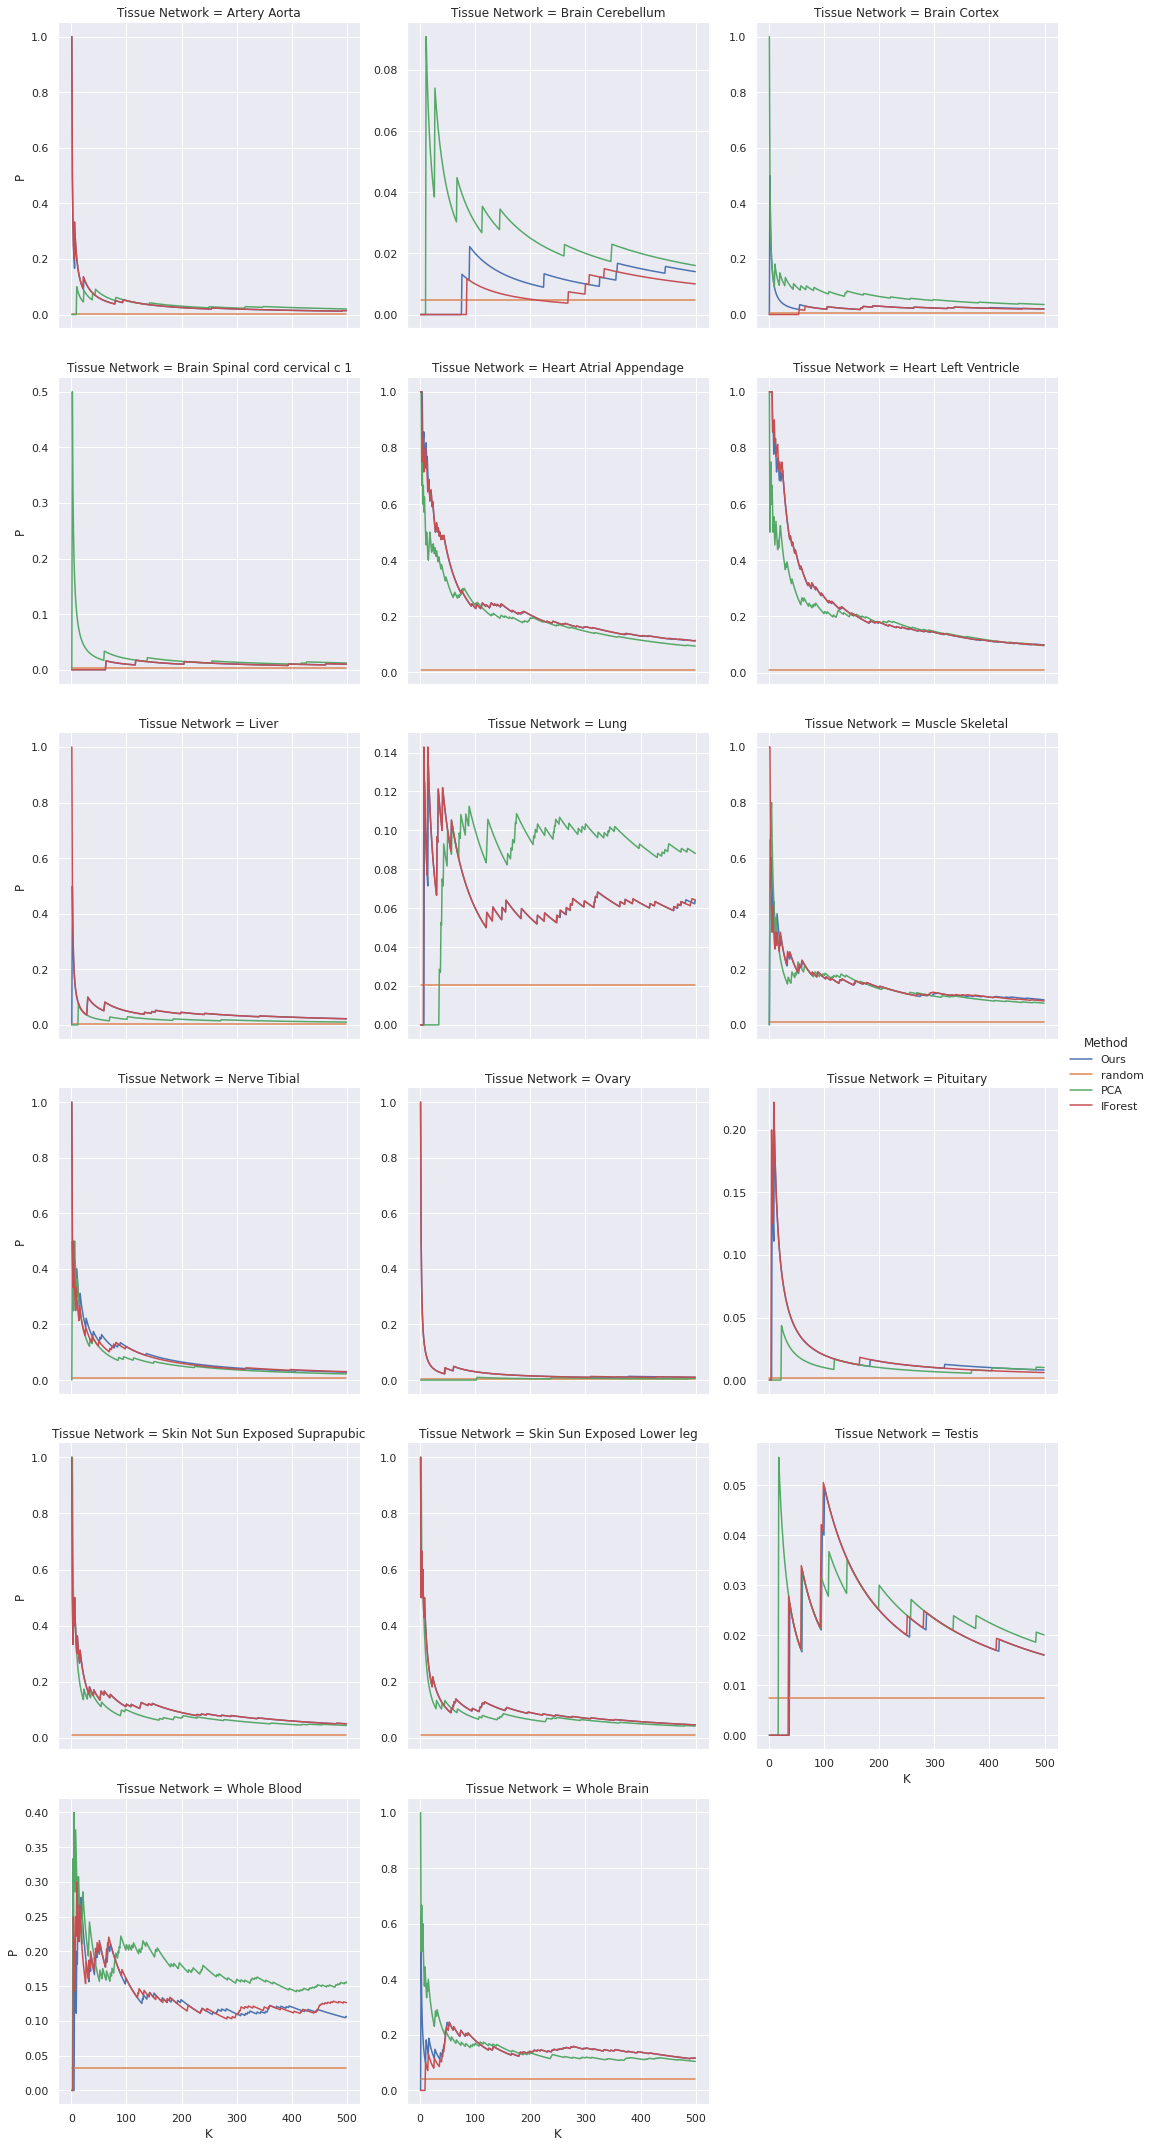

In [735]:
import seaborn as sns
sns.set_theme()
g = sns.relplot(data=df_concat[df_concat.K<500],x="K", y="P", hue="Method", col="Tissue Network", kind="line",col_wrap=3,  facet_kws={'sharey': False, 'sharex': True})


In [679]:
df_concat[df_concat.K<1000].groupby("Tissue Network")["is_labeled_disease"].sum() /df_concat[df_concat.K<500].groupby("Tissue Network")["is_labeled_disease"].sum()

Tissue Network
Artery Aorta                       1.428571
Brain Cerebellum                   1.428571
Brain Cortex                       2.200000
Brain Spinal cord cervical c 1     1.400000
Heart Atrial Appendage             1.125000
Heart Left Ventricle               1.224490
Liver                              1.181818
Lung                               1.906250
Muscle Skeletal                    1.177778
Nerve Tibial                       1.214286
Ovary                              1.400000
Pituitary                          1.500000
Skin Not Sun Exposed Suprapubic    1.120000
Skin Sun Exposed Lower leg         1.217391
Testis                             2.250000
Whole Blood                        2.094340
Whole Brain                        1.396552
Name: is_labeled_disease, dtype: float64

In [637]:
scores[:,0].max()

20.683789486591213

In [621]:
from pyod.utils.utility import standardizer

# scores have to be normalized before combination
standardizer(X)

array([[ 2.57256092],
       [-0.58428499],
       [ 0.24123033],
       ...,
       [-0.40827119],
       [ 3.48712439],
       [ 1.27723873]])

In [622]:
standardizer(scores)

array([[ 2.57256092,  1.61374699,  2.5410071 ,  0.25228617],
       [-0.58428499, -0.22724049, -0.58809812,  0.01433199],
       [ 0.24123033, -0.11917302, -0.04875848,  0.06441055],
       ...,
       [-0.40827119,  0.01279324, -0.58809812, -0.02272979],
       [ 3.48712439,  3.16854384,  3.15441604,  2.77681322],
       [ 1.27723873,  0.5757469 ,  1.44792205, -0.26538339]])

In [614]:
clf.predict_proba(X)[:,1]

array([0.54288032, 0.05332823, 0.18134612, ..., 0.0806238 , 0.68470748,
       0.3420065 ])

In [587]:
clf.decision_scores_

array([ 0.08315144, -0.14440232, -0.08489701, ..., -0.13171479,
        0.14907558, -0.01021879])

In [474]:
singmoid = lambda x: 1/(1 + np.exp(-x))


In [650]:
pd.DataFrame(res).set_index("comb_method").loc["moa"]

,tissue_name,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
moa,Artery Aorta,1.0,0.333333,0.2,0.10,0.130435,23
moa,Brain Cerebellum,0.0,0.000000,0.0,0.00,0.000000,65
moa,Brain Cortex,0.0,0.333333,0.1,0.05,0.025974,77
moa,Brain Spinal cord cervical c 1,0.0,0.000000,0.0,0.00,0.000000,48
moa,Heart Atrial Appendage,1.0,1.000000,0.8,0.65,0.240602,133
moa,Heart Left Ventricle,1.0,1.000000,0.8,0.70,0.224638,138
moa,Liver,1.0,0.333333,0.1,0.05,0.056604,53
moa,Lung,0.0,0.000000,0.1,0.10,0.062044,274
moa,Muscle Skeletal,0.0,0.666667,0.4,0.30,0.157025,121


In [651]:
pd.DataFrame(res).set_index("comb_method").loc["maximization"]

,tissue_name,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
maximization,Artery Aorta,1.0,0.333333,0.2,0.10,0.130435,23
maximization,Brain Cerebellum,0.0,0.000000,0.0,0.00,0.000000,65
maximization,Brain Cortex,0.0,0.333333,0.1,0.05,0.025974,77
maximization,Brain Spinal cord cervical c 1,0.0,0.000000,0.0,0.00,0.000000,48
maximization,Heart Atrial Appendage,1.0,1.000000,0.8,0.65,0.240602,133
maximization,Heart Left Ventricle,1.0,1.000000,0.8,0.70,0.224638,138
maximization,Liver,1.0,0.333333,0.1,0.05,0.056604,53
maximization,Lung,0.0,0.000000,0.1,0.10,0.062044,274
maximization,Muscle Skeletal,0.0,0.666667,0.4,0.30,0.157025,121


In [646]:
pd.DataFrame(res).groupby("comb_method").mean()

,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,
aom,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
average,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
maximization,0.470588,0.333333,0.247059,0.188235,0.095680,142.941176
median,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
moa,0.470588,0.333333,0.247059,0.188235,0.095680,142.941176


In [631]:
pd.DataFrame(res).groupby("comb_method").mean()

,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,
aom,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
average,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
maximization,0.352941,0.313725,0.194118,0.155882,0.089488,142.941176
median,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
moa,0.352941,0.313725,0.194118,0.155882,0.089488,142.941176


In [634]:
iforest_res.mean()

auc         0.630864
p@1         0.529412
p@3         0.294118
p@10        0.241176
p@20        0.179412
p@anom      0.096444
anom      142.941176
dtype: float64

In [635]:
pd.DataFrame(res).groupby("comb_method").mean()

,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,
aom,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
average,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
maximization,0.352941,0.313725,0.194118,0.155882,0.089488,142.941176
median,0.352941,0.333333,0.205882,0.173529,0.101048,142.941176
moa,0.352941,0.313725,0.194118,0.155882,0.089488,142.941176


In [611]:
pd.DataFrame(res).groupby("comb_method").mean()

,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,
aom,0.411765,0.352941,0.252941,0.191176,0.097132,142.941176
average,0.411765,0.352941,0.252941,0.191176,0.097132,142.941176
maximization,0.294118,0.333333,0.247059,0.188235,0.095465,142.941176
median,0.294118,0.294118,0.217647,0.170588,0.096004,142.941176
moa,0.294118,0.333333,0.247059,0.188235,0.095465,142.941176


In [581]:
pd.DataFrame(res).groupby("comb_method").mean()

,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
aom,0.630864,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
average,0.630864,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
maximization,0.630864,0.411765,0.333333,0.247059,0.188235,0.095680,142.941176
median,0.630864,0.294118,0.352941,0.235294,0.200000,0.105413,142.941176
moa,0.630864,0.411765,0.333333,0.247059,0.188235,0.095680,142.941176


In [585]:
hbos_res.mean()

auc         0.619844
p@1         0.294118
p@3         0.196078
p@10        0.188235
p@20        0.141176
p@anom      0.079025
anom      142.941176
dtype: float64

In [583]:
pac_res_1.mean()

p@1     0.352941
p@3     0.313725
p@10    0.194118
p@20    0.155882
dtype: float64

In [528]:
pd.DataFrame(res).mean()

auc         0.630864
p@1         0.411765
p@3         0.352941
p@10        0.241176
p@20        0.194118
p@anom      0.101220
anom      142.941176
dtype: float64

In [469]:
pd.DataFrame(res).mean()

auc         0.626953
p@1         0.294118
p@3         0.352941
p@10        0.235294
p@20        0.197059
p@anom      0.102895
anom      142.941176
dtype: float64

In [450]:
iforest_res.mean()

auc         0.630864
p@1         0.529412
p@3         0.294118
p@10        0.241176
p@20        0.179412
p@anom      0.096444
anom      142.941176
dtype: float64

In [436]:
clf.decision_scores_.shape

(13523,)

In [438]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(clf.decision_scores_.reshape(-1, 1))
probs1 = scaler.transform(clf.decision_scores_.reshape(-1, 1)).ravel().clip(0, 1)
scaler = MinMaxScaler().fit(+X_pca[:,1].reshape(-1, 1))
probs2 = scaler.transform(X_pca[:,1].reshape(-1, 1)).ravel().clip(0, 1)

In [441]:
precision_at_k(y, (probs1+probs2),20)

0.15

In [425]:
clf.decision_scores_

array([-0.06675581, -0.13499522, -0.12180967, ..., -0.09953965,
       -0.09786919, -0.07493755])

In [426]:
X_pca[:,1]

array([-0.01906967,  0.01343106, -0.00063871, ...,  0.0191467 ,
       -0.17674728, -0.02688917])

In [423]:
pd.DataFrame(res).mean()

auc         0.662210
p@1         0.058824
p@3         0.117647
p@10        0.105882
p@20        0.091176
p@anom      0.054961
anom      142.941176
dtype: float64

In [362]:
pac_res_1

,tissue_name,p@1,p@3,p@10,p@20
0,Artery Aorta,0.0,0.000000,0.1,0.05
1,Brain Cerebellum,0.0,0.000000,0.0,0.05
2,Brain Cortex,1.0,0.333333,0.1,0.15
3,Brain Spinal cord cervical c 1,0.0,0.333333,0.1,0.05
4,Heart Atrial Appendage,1.0,0.666667,0.5,0.45
5,Heart Left Ventricle,1.0,0.666667,0.5,0.50
6,Liver,0.0,0.000000,0.0,0.05
7,Lung,0.0,0.000000,0.0,0.00
8,Muscle Skeletal,0.0,0.666667,0.4,0.25
9,Nerve Tibial,0.0,0.333333,0.3,0.20


In [407]:
pd.DataFrame(res).mean()

auc         0.605424
p@1         0.058824
p@3         0.039216
p@10        0.058824
p@20        0.061765
p@anom      0.051860
anom      142.941176
dtype: float64

In [366]:
iforest_res

,tissue_name,auc,p@1,p@3,p@10,p@20,p@anom,anom
0,Artery Aorta,0.794172,1.0,0.333333,0.2,0.10,0.130435,23
1,Brain Cerebellum,0.509018,0.0,0.000000,0.0,0.00,0.000000,65
2,Brain Cortex,0.661900,0.0,0.000000,0.0,0.00,0.025974,77
3,Brain Spinal cord cervical c 1,0.620535,0.0,0.000000,0.0,0.00,0.000000,48
4,Heart Atrial Appendage,0.737339,1.0,1.000000,0.8,0.65,0.240602,133
5,Heart Left Ventricle,0.718500,1.0,1.000000,0.9,0.75,0.224638,138
6,Liver,0.625194,1.0,0.333333,0.1,0.05,0.056604,53
7,Lung,0.619858,0.0,0.000000,0.1,0.10,0.062044,274
8,Muscle Skeletal,0.736250,1.0,0.666667,0.3,0.30,0.157025,121
9,Nerve Tibial,0.571653,1.0,0.333333,0.3,0.20,0.129870,77


In [365]:
ecod_res = pd.DataFrame(res)

In [378]:
pca_tran = PCA(n_components=2, random_state=2).fit(X)
X_pca = pca_tran.transform(X)

In [381]:
X_pca.shape

(13523, 2)

In [383]:
precision_at_k(y, X_pca[:,1],y.sum())

0.10106382978723404

In [384]:
precision_at_k(y, X_pca[:,0],y.sum())

0.10815602836879433

In [398]:
sorted_probas = sorted(zip(X_pca[:,1], y), key=lambda x: x[0], reverse=False)


In [399]:
tmp = pd.DataFrame(sorted_probas)

In [400]:
precision_at_k(tmp[1], tmp[0],y.sum(), True)

0.040780141843971635

In [715]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from NetAnom.utils import precision_at_k
from sklearn.model_selection import cross_validate
from pyod.models.iforest import IForest

from pyod.models.ecod import ECOD

from pyod.models.hbos import HBOS

warnings.filterwarnings('ignore')
res = []
df_concat2=[]

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping

for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    
    with (models_path/f"{tissue_name}_RandNE.pkl").open("rb") as f:
        nc = pickle.load( f)
    X, y, genes = nc.get_node_training_data(False, False,True)

    # clf = IForest(n_jobs=-1, random_state=2)
    pca_tran = PCA(n_components=2, random_state=2).fit(X)
    X_pca = pca_tran.transform(X)[:,1]
    # X_pca = pca_tran.transform(X)

    temp["tissue_name"]  = tissue_name     
    temp["p@1"] = precision_at_k(y, X_pca,1)
    temp["p@3"] = precision_at_k(y, X_pca,3)
    temp["p@10"] = precision_at_k(y, X_pca,10)
    temp["p@20"] = precision_at_k(y, X_pca,20)
    temp["p@anom"] = precision_at_k(y, X_pca,y.sum())
    temp["anom"] = y.sum()
    res.append(temp)      
    df_concat2.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": X_pca, "is_labeled_disease":y, "gene":genes}))
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:
    # break

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [293]:
# iforest_res = pd.DataFrame(res)
print(iforest_res.mean())

auc     0.618899
p@1     0.352941
p@3     0.215686
p@10    0.205882
p@20    0.155882
dtype: float64


In [291]:
# hbos_res = pd.DataFrame(res)
print(hbos_res.mean())

auc     0.615974
p@1     0.352941
p@3     0.196078
p@10    0.135294
p@20    0.132353
dtype: float64


In [294]:
# ecod_res_1 = pd.DataFrame(res)
print(ecod_res_1.mean())

auc     0.606452
p@1     0.352941
p@3     0.254902
p@10    0.176471
p@20    0.158824
dtype: float64


In [289]:
pac_res_1.mean()

p@1     0.352941
p@3     0.313725
p@10    0.194118
p@20    0.155882
dtype: float64

## Single Feature

In [57]:
df_agg = nc.get_node_features()
df_agg = df_agg.sample(frac=1, random_state=2).drop(columns=["id", "gen_name"])

# X, y = df_agg.drop(columns=["disease"]).values, df_agg["disease"].values

NameError: name 'nc' is not defined

In [47]:
feature = "diff_std"
for treshold in np.linspace(df_agg[feature].min(), df_agg[feature].max(), 50):
    print(f'{treshold}: {precision_at_k(df_agg["disease"], df_agg[feature] > treshold,20)}')

0.0: 0.0
0.0020942971727241464: 0.0
0.004188594345448293: 0.0
0.0062828915181724395: 0.0
0.008377188690896585: 0.05
0.010471485863620731: 0.05
0.012565783036344879: 0.0
0.014660080209069025: 0.0
0.01675437738179317: 0.0
0.018848674554517317: 0.0
0.020942971727241463: 0.0
0.02303726889996561: 0.0
0.025131566072689758: 0.0
0.027225863245413904: 0.0
0.02932016041813805: 0.0
0.03141445759086219: 0.05
0.03350875476358634: 0.05
0.03560305193631049: 0.05
0.037697349109034634: 0.05
0.03979164628175878: 0.05
0.041885943454482925: 0.05
0.043980240627207075: 0.05
0.04607453779993122: 0.0
0.04816883497265537: 0.0
0.050263132145379516: 0.0
0.05235742931810366: 0.0
0.05445172649082781: 0.0
0.05654602366355195: 0.0
0.0586403208362761: 0.0
0.06073461800900024: 0.0
0.06282891518172438: 0.0
0.06492321235444853: 0.0
0.06701750952717268: 0.0
0.06911180669989683: 0.0
0.07120610387262098: 0.0
0.07330040104534512: 0.0
0.07539469821806927: 0.0
0.07748899539079342: 0.0
0.07958329256351757: 0.0
0.08167758973624

## Generate Predictions

In [144]:
selected_tissue_mapping

,tissue_name_network_file,tissue_name_disease_file,disease_nodes_num
2,Artery Aorta,Artery Aorta,26
5,Brain Cerebellum,Brain Cerebellum,77
6,Brain Cortex,Brain Cortex,86
11,Brain Spinal cord cervical c 1,Spinal cord,56
13,Breast Mammary Tissue,Mammary gland,27
17,Heart Atrial Appendage,Heart Atrium,144
18,Heart Left Ventricle,Heart Ventricle,150
19,Liver,Liver,64
20,Lung,Respiratory system Lung,310
21,Minor Salivary Gland,Mammary gland,27


In [174]:
?LogisticRegression

Init signature: LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
floats for optimal performance; any other input format wi

In [ ]:
selected_tissue_mapping.iloc[2:3]

,tissue_name_network_file,tissue_name_disease_file,disease_nodes_num
6,Brain Cortex,Brain Cortex,86


In [ ]:
solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'},             default='lbfgs'


In [ ]:
            ]

             (GaussianNB,{}),

In [642]:
dfs = []
for _, line in tqdm(selected_tissue_mapping.iloc[2:3].iterrows(), total=len(selected_tissue_mapping)):
    tissue_name = line["tissue_name_network_file"]
    tissue_name_disease_file = line["tissue_name_disease_file"]
    with (models_path/f"{tissue_name}.pkl").open("rb") as f:
        nc = pickle.load( f)
    # nc.train_node_meta_classifier(ECOD, {}, cross_val=True)
    # nc.train_node_meta_classifier( LogisticRegression, {"n_jobs":-1,"random_state":2, "C": 0.8, "class_weight":{0:1,1:10}, "max_iter":400, 'penalty':"l2", "solver":"newton-cg"}, cross_val=False, return_train_score=True)
    nc.train_node_meta_classifier(n_clf, n_clf_params, cross_val=False)
    ids, scores = nc.get_node_probas2()
    pred_df = pd.DataFrame(ids)
    pred_df["scores"] = scores
    pred_df = pred_df.sort_values("scores", ascending= False)
    pred_df["Tissue Network"] = tissue_name
    dfs.append(pred_df)
    # break
    
pd.concat(dfs).to_csv(f"new_predeictions7.csv")    
    

  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
EasyEnsembleClassifier()

In [647]:
# nc.train_node_meta_classifier( EasyEnsembleClassifier, {"base_estimator":LogisticRegression(),"sampling_strategy":0.9, 'random_state':1}, cross_val=True, return_train_score=True)
nc.train_node_meta_classifier(n_clf, n_clf_params, cross_val=False)
ids, scores = nc.get_node_probas2()
pred_df = pd.DataFrame(ids)
pred_df["scores"] = scores
pred_df = pred_df.sort_values("scores", ascending= False)
pred_df["Tissue Network"] = tissue_name
pred_df["rank"]=range(len(pred_df))
pred_df[pred_df["gen_name"]=="ENSG00000197386"]

,gen_name,scores,Tissue Network,rank
gen,,,,
12515,ENSG00000197386,0.095412,Brain Cortex,8


In [610]:
df_concat = pd.concat(dfs)
disease_info2 = disease_info.merge(tissue_mapping, left_on=["Tissue"], right_on=["tissue_name_disease_file"])
disease_info2 = disease_info2[["Gene_name","Gene_ID","tissue_name_network_file"]]
disease_info2 = disease_info2.drop_duplicates()
df_concat = df_concat.merge(disease_info2, left_on=["gen_name", "Tissue Network"], right_on=["Gene_ID", "tissue_name_network_file"], how="left")
df_concat["is_labeled_disease"] = ~df_concat["Gene_ID"].isna()
df_concat = df_concat[["gen_name","scores","Tissue Network", "is_labeled_disease"]]
df_concat = df_concat.rename(columns={"gen_name": "gene_name", "scores": "abnormality_score"})
df_concat["degree"] = df_concat["gene_name"].apply(lambda v: g.degree[v])

In [611]:
df_top10 = df_concat.groupby("Tissue Network").head(10)

In [612]:
df_top10 = df_top10.merge(df_top10.groupby("gene_name").size().reset_index())

In [613]:
df_top10["is_in_top10_multiple_tissues"] = df_top10[0]>1

In [614]:
df_top10 = df_top10.drop(columns=[0])

In [615]:
df_top10.to_csv(out_path/"top-10-4.csv")

In [604]:
df_top10[df_top10["gene_name"]=="ENSG00000197386"]

,gene_name,abnormality_score,Tissue Network,is_labeled_disease,degree,is_in_top10_multiple_tissues


In [633]:
df_concat = df_concat.sort_values(["abnormality_score",	"Tissue Network"],ascending=False)

In [635]:
df_concat["rank"] = df_concat.groupby('Tissue Network')['abnormality_score'].rank('first')

In [ ]:
df_concat[df_concat["gene_name"]=="ENSG00000197386"]

In [640]:
df_concat[df_concat["Tissue Network"]=="Whole Brain"].head(20)

,gene_name,abnormality_score,Tissue Network,is_labeled_disease,degree,rank
243414,ENSG00000131095,0.251475,Whole Brain,False,46,13523.0
243415,ENSG00000156475,0.232255,Whole Brain,True,174,13522.0
243416,ENSG00000104833,0.224606,Whole Brain,True,79,13521.0
243417,ENSG00000132639,0.215517,Whole Brain,False,25,13520.0
243418,ENSG00000105613,0.215136,Whole Brain,False,39,13519.0
243419,ENSG00000184221,0.210633,Whole Brain,False,17,13518.0
243420,ENSG00000078328,0.202359,Whole Brain,False,33,13517.0
243421,ENSG00000155980,0.200360,Whole Brain,True,19,13516.0
243422,ENSG00000067606,0.200007,Whole Brain,False,67,13515.0
243423,ENSG00000080824,0.199651,Whole Brain,False,711,13514.0


In [639]:
df_concat[df_concat["gene_name"]=="ENSG00000197386"]

,gene_name,abnormality_score,Tissue Network,is_labeled_disease,degree,rank
243472,ENSG00000197386,0.168641,Whole Brain,False,283,13465.0
27054,ENSG00000197386,0.095412,Brain Cortex,False,283,13515.0
108409,ENSG00000197386,0.086206,Lung,False,283,13298.0
67878,ENSG00000197386,0.071931,Heart Atrial Appendage,False,283,13260.0
230928,ENSG00000197386,0.068114,Whole Blood,False,283,12486.0
81450,ENSG00000197386,0.054639,Heart Left Ventricle,False,283,13211.0
148860,ENSG00000197386,0.034813,Nerve Tibial,False,283,13416.0
40667,ENSG00000197386,0.030352,Brain Spinal cord cervical c 1,False,283,13425.0
135743,ENSG00000197386,0.026655,Muscle Skeletal,False,283,13010.0
203397,ENSG00000197386,0.021764,Skin Sun Exposed Lower leg,False,283,12971.0


In [356]:
disease_info[disease_info["Gene_ID"]=="ENSG00000116478"]

,Disease_name,Gene_name,Gene_ID,Tissue


In [ ]:
Artery Aorta

In [ ]:
dfs = []
for _, line in tqdm(tmp.iterrows(), total=len(tmp)):
    tissue_name = line["Tissue Network"]
    tissue_name_disease_file = line["Tissue Disease File"]
    l_clf, l_clf_parmas = link_clfs_dict[line["Weight Clf"]]
    n_clf, n_clf_params = node_clfs_dict[line["Node Clf"]]
    
    try:
        g = load_tissue_graph(tissue_name, tissue_name_disease_file)
    except KeyError:
        # print(f"{tissue_name} not found in disease info")
        continue
    nc = NodeClassifier(g)
    nc.set_gdf_features(edge_df["features"])
    nc.eval["Tissue Network"] = tissue_name
    nc.eval["Tissue Disease File"] = tissue_name_disease_file
    nc.train_weight_classifier(l_clf, l_clf_parmas, False)
    ids, scores = nc.get_node_probas2(n_clf, n_clf_params,calibrator=None)
    pred_df = pd.DataFrame(ids)
    pred_df["scores"] = scores
    pred_df = pred_df.sort_values("scores", ascending= False)
    pred_df["Tissue Network"] = tissue_name
    dfs.append(pred_df)
pd.concat(dfs).to_csv(f"predeiction11.csv")    
    

## Deep Learning

In [660]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import precision_score, f1_score, recall_score

class Precision(Metric):
    def __init__(self):
        self._name = "precision"
        self._maximize = True

    def __call__(self, y_true, y_score):
        return precision_score(y_true, y_score[:, 1]>0.5)

class Recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = False

    def __call__(self, y_true, y_score):
        # print(y_true)
        return recall_score(y_true, y_score[:, 1]>0.5)

class F1(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        # print(y_true)
        return f1_score(y_true, y_score[:, 1]>0.5)
    
class Precision_20(Metric):
    def __init__(self):
        self._name = "precision@20"
        self._maximize = True

    def __call__(self, y_true, y_score):
        k = 20
        preds = list(y_score[:, 1])
        sorted_probas = sorted(zip(preds, y_true), key=lambda x: x[0], reverse=True)
        return sum([line[1] for line in sorted_probas[:k]]) / k 


In [48]:
train_pos, test_pos = train_test_split(df_agg[df_agg["disease"]==1], test_size=0.2,random_state=2)
train_neg, test_neg = train_test_split(df_agg[df_agg["disease"]==0], test_size=len(test_pos)*5,random_state=2)


In [49]:
X_train = train_pos.append(train_neg)
X_valid = test_pos.append(test_neg)
Y_train = X_train.pop("disease")
y_valid = X_valid.pop("disease")

In [50]:
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 13393), (1, 13393)]


In [ ]:
Tissue Network	Tissue Disease File

In [679]:
x = pd.DataFrame(tissue_res).mean()

In [681]:
x["e"] = 7

In [705]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from NetAnom.utils import precision_at_k

dfs = []
preds = []

for _, line in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    tissue_name = line["tissue_name_network_file"]
    tissue_name_disease_file = line["tissue_name_disease_file"]
    with (models_path/f"{tissue_name}.pkl").open("rb") as f:
        nc = pickle.load( f)
        
    df_agg = nc.get_node_features()
    df_agg = df_agg.drop(columns=["id"])

    skf = StratifiedKFold(n_splits=10, random_state=2021, shuffle=True)

    y = df_agg["disease"]
    X = df_agg.drop(columns=["disease"])
    tissue_res = []
    tmp_preds = {"gene": [], "pred": [], "y": []}
    gen_name = X.pop("gen_name")

    for k, (train_index, valid_index) in enumerate(skf.split(X, y)):
        res = {"fold": k}
        tmp_preds["gene"] = np.concatenate([tmp_preds["gene"], gen_name.values[valid_index]])
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y.values[train_index], y.values[valid_index]
        
        tmp_preds["y"] = np.concatenate([tmp_preds["y"], y_valid])

        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample( X_train, y_train)

        clf = TabNetClassifier(optimizer_params=dict(lr=2e-2),n_steps=5, verbose=0)  #TabNetRegressor()
        clf.fit(
          X_resampled, y_resampled,patience=15,
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_name=['train', 'valid'],
          eval_metric=['auc', F1, Precision, Precision_20]
        )

        test_preds = clf.predict_proba(X_valid)
        
        tmp_preds["pred"] = np.concatenate([tmp_preds["pred"], test_preds[:,1]])

        res["test_auc"] = roc_auc_score(y_valid, test_preds[:,1])
        res["test_precision_at_1"] = precision_at_k(y_valid, test_preds[:,1], 1)
        res["test_precision_at_3"] = precision_at_k(y_valid, test_preds[:,1], 3)
        res["test_precision_at_10"] = precision_at_k(y_valid, test_preds[:,1], 10)
        res["test_precision_at_20"] = precision_at_k(y_valid, test_preds[:,1], 20)
        res["test_precision"] = recall_score(y_valid, test_preds[:,1]>0.5)
        res["test_recall"] = precision_score(y_valid, test_preds[:,1]>0.5)

        train_preds = clf.predict_proba(X_train)

        res["train_auc"] = roc_auc_score(y_train, train_preds[:,1])
        res["train_precision_at_1"] = precision_at_k(y_train, train_preds[:,1], 1)
        res["train_precision_at_3"] = precision_at_k(y_train, train_preds[:,1], 3)
        res["train_precision_at_10"] = precision_at_k(y_train, train_preds[:,1], 10)
        res["train_precision_at_20"] = precision_at_k(y_train, train_preds[:,1], 20)
        res["train_precision"] = recall_score(y_train, train_preds[:,1]>0.5)
        res["train_recall"] = precision_score(y_train, train_preds[:,1]>0.5)
        	

        tissue_res.append(res)
        # df_sub[model.classes_] += test_preds
    tmp = pd.DataFrame(tissue_res).mean()
    tmp["Tissue Network"] = tissue_name
    tmp["Tissue Disease File"] = tissue_name_disease_file
    tmp["Anomalies"] = len(df_agg[df_agg["disease"]==1])
    tmp["Weight Clf"] = "TabNet"
    preds.append(tmp_preds)
    dfs.append(tmp)


# df_sub[model.classes_] = df_sub[model.classes_] / NB_FOLDS

  0%|          | 0/19 [00:00<?, ?it/s]


Early stopping occurred at epoch 15 with best_epoch = 0 and best_valid_precision@20 = 0.05
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 15 with best_epoch = 0 and best_valid_precision@20 = 0.05
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 9 and best_valid_precision@20 = 0.05
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 15 with best_epoch = 0 and best_valid_precision@20 = 0.05
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 17 with best_epoch = 2 and best_valid_precision@20 = 0.1
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 15 with best_epoch = 0 and best_valid_precision@20 = 0.0
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 15 with best_epoch = 0 and best_valid_precision@20 = 0.0
Best weights from best epoch are automati

In [722]:
selected_tissue_mappinga

,tissue_name_network_file,tissue_name_disease_file,disease_nodes_num
2,Artery Aorta,Artery Aorta,26
5,Brain Cerebellum,Brain Cerebellum,77
6,Brain Cortex,Brain Cortex,86
11,Brain Spinal cord cervical c 1,Spinal cord,56
13,Breast Mammary Tissue,Mammary gland,27
17,Heart Atrial Appendage,Heart Atrium,144
18,Heart Left Ventricle,Heart Ventricle,150
19,Liver,Liver,64
20,Lung,Respiratory system Lung,310
21,Minor Salivary Gland,Mammary gland,27


In [727]:
for i, (_, line) in enumerate(selected_tissue_mapping.iterrows()):
    preds[i]["tissue"] = line["tissue_name_network_file"]

In [728]:
x = pd.concat([pd.DataFrame(line) for line in preds])

In [729]:
x

,gene,pred,y,tissue
0,ENSG00000112562,0.615491,0.0,Artery Aorta
1,ENSG00000140545,0.628526,0.0,Artery Aorta
2,ENSG00000122176,0.635270,0.0,Artery Aorta
3,ENSG00000179772,0.628092,0.0,Artery Aorta
4,ENSG00000054938,0.609121,0.0,Artery Aorta
...,...,...,...,...
13518,ENSG00000108823,0.434736,0.0,Whole Brain
13519,ENSG00000102007,0.459694,0.0,Whole Brain
13520,ENSG00000182704,0.414098,0.0,Whole Brain
13521,ENSG00000131471,0.414380,0.0,Whole Brain


In [723]:
preds[0]["tissue"] = "Artery Aorta"

In [717]:
x = pd.DataFrame(preds[2])

In [730]:
x = x.sort_values("pred", ascending=False)

In [732]:
df_top10 = x.groupby("tissue").head(10)

In [734]:
df_top10.sort_values(["tissue","pred"], ascending=False)

,gene,pred,y,tissue
12900,ENSG00000142192,0.996128,1.0,Whole Brain
11511,ENSG00000135679,0.966537,0.0,Whole Brain
4755,ENSG00000036257,0.941324,0.0,Whole Brain
12862,ENSG00000136997,0.931655,0.0,Whole Brain
10194,ENSG00000146648,0.928496,0.0,Whole Brain
...,...,...,...,...
501,ENSG00000055130,0.999931,0.0,Artery Aorta
527,ENSG00000135679,0.999850,0.0,Artery Aorta
529,ENSG00000164924,0.999460,0.0,Artery Aorta
464,ENSG00000182199,0.998098,0.0,Artery Aorta


In [735]:
df_top10 = df_top10.rename(columns={"y": "is_labeled_disease", "gene" : "gene_name", "pred":"abnormality_score", "tissue":"Tissue Network"})

In [737]:
df_top10.to_csv("top-10-tabnet.csv", index=False)

In [718]:
gene_name	abnormality_score	Tissue Network is_labeled_diseasea

,gene,pred,y
5987,ENSG00000197386,0.997538,0.0


,gene,pred,y
717,ENSG00000066044,1.000000,0.0
635,ENSG00000162231,0.999998,0.0
6117,ENSG00000150991,0.999790,0.0
1988,ENSG00000135679,0.999738,0.0
591,ENSG00000044090,0.999471,0.0
11540,ENSG00000136997,0.998711,0.0
6086,ENSG00000187531,0.998334,0.0
2371,ENSG00000106211,0.997975,0.0
6056,ENSG00000096401,0.997797,0.0
5987,ENSG00000197386,0.997538,0.0


In [688]:
tmp_preds["gene"]

[]

In [702]:
np.concatenate([tmp_preds["gene"], gen_name.values[valid_index]]).shape

(2706,)

array(['ENSG00000112562', 'ENSG00000140545', 'ENSG00000122176', ...,
       'ENSG00000196581', 'ENSG00000125851', 'ENSG00000106078'],
      dtype=object)

In [53]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetClassifier(optimizer_params=dict(lr=2e-2),n_steps=5)  #TabNetRegressor()
clf.fit(
  X_resampled, y_resampled,patience=15,
  eval_set=[(X_train.values, Y_train.values), (X_valid.values, y_valid.values)],
  eval_name=['train', 'valid'],
  eval_metric=['auc', F1, Precision, Precision_20]
)
# preds = clf.predict(X_test)


Device used : cpu
epoch 0  | loss: 0.76163 | train_auc: 0.59973 | train_f1: 0.01852 | train_precision: 0.01025 | train_precision@20: 0.05    | valid_auc: 0.59882 | valid_f1: 0.23529 | valid_precision: 0.5     | valid_precision@20: 0.2     |  0:00:49s
epoch 1  | loss: 0.62247 | train_auc: 0.50465 | train_f1: 0.025   | train_precision: 0.01493 | train_precision@20: 0.05    | valid_auc: 0.4284  | valid_f1: 0.14286 | valid_precision: 1.0     | valid_precision@20: 0.1     |  0:00:54s
epoch 2  | loss: 0.61263 | train_auc: 0.58627 | train_f1: 0.01376 | train_precision: 0.00707 | train_precision@20: 0.0     | valid_auc: 0.63314 | valid_f1: 0.27273 | valid_precision: 0.33333 | valid_precision@20: 0.2     |  0:00:58s
epoch 3  | loss: 0.59023 | train_auc: 0.57048 | train_f1: 0.0083  | train_precision: 0.00418 | train_precision@20: 0.0     | valid_auc: 0.67219 | valid_f1: 0.35714 | valid_precision: 0.23256 | valid_precision@20: 0.25    |  0:01:02s
epoch 4  | loss: 0.58112 | train_auc: 0.50815 | tr

In [56]:
lclf = LogisticRegression(class_weight="balanced")
lclf.fit(X_train.values, Y_train.values)

LogisticRegression(class_weight='balanced')

In [57]:
precision_at_k(y_valid, lclf.predict_proba(X_valid)[:,1], 20)

0.25

In [58]:
roc_auc_score(y_valid, lclf.predict_proba(X_valid)[:,1])

0.6390532544378699

In [125]:
tissue = df_concat[df_concat["Tissue Network"]=="Whole Blood"]

In [126]:
testy, lr_probs = tissue["is_labeled_disease"], tissue["abnormality_score"]

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.700


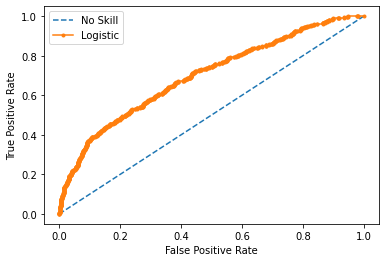

In [127]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset

ns_probs = [0 for _ in range(len(testy))]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [53]:
1

1